In [1]:
import sys
sys.path.append("E:/university/Year 5 Spring/FYT/code/multi_modal_ser")
from utils.const import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio

In [2]:
# Define const path
SPEC_PATH = "E:/datasets/preprocessed/spectrogram"
AST_PATH = os.path.join(SPEC_PATH, "ast")
LIBROSA_PATH = os.path.join(SPEC_PATH, "librosa")
INV_AST_PATH = os.path.join(SPEC_PATH, "inv_ast")
INV_LIBROSA_PATH = os.path.join(SPEC_PATH, "inv_librosa")
RAW_PATH = os.path.join(SPEC_PATH, "raw")

In [3]:
MAX_LEN = 1024
NORM_SPEC = False
HOP_LENGTH = None

### extract audio data

In [4]:
video_rate = 30

from scipy.io import wavfile
import time

spectrogramPATH = 'E:/datasets/preprocessed/spectrogram'
audio_data_list = []

now = time.time()
for ses in range(3, 6):
    extractionmapPATH = 'E:/datasets/preprocessed/extractionmap/cut_extractionmap' + \
        str(ses)+'.xlsx'
    xl = pd.ExcelFile(extractionmapPATH)
    sheets = xl.sheet_names
    spectrogramPATH = spectrogramPATH+'/Session'+str(ses)+'/'
    wavPATH = 'E:/datasets/IEMOCAP_full_release.tar/IEMOCAP_full_release/IEMOCAP_full_release/Session' + \
        str(ses)+'/dialog/wav/'
    for sheet in sheets:
        fileNAME = sheet+'.wav'
        spectrogramPATH = spectrogramPATH+fileNAME+'/'
        audio_rate, data = wavfile.read(wavPATH+fileNAME)
        sheet_df = xl.parse(sheet)
        iframe = np.array(sheet_df['iframe'])
        fframe = np.array(sheet_df['fframe'])
        smp_ids = np.array(sheet_df['smp_id'])
        
        idx = 1
        for idx in range(len(smp_ids)):
            multiframedata = data[iframe[idx]*int(audio_rate/video_rate):(fframe[idx]+1)*int(audio_rate/video_rate)]
            multiframedata = multiframedata.astype('float64').mean(axis=1)
            audio_data_list.append({
                "id": smp_ids[idx],
                "data": multiframedata,
            })
print("Extracting Audios: ", time.time()-now)

Extracting Audios:  8.885225057601929


In [5]:
print(len(audio_data_list))
audio_data_list[0]

6409


{'id': 'Ses03F_impro01_F000',
 'data': array([ -6.5, -11. , -23.5, ..., -44. , -29. , -12. ])}

### Define util funcs

In [6]:
# Noticed that the spectrograms here are all before normalization and logged
import librosa
from transformers import ASTFeatureExtractor, ASTModel
from scipy.io.wavfile import write

processor = ASTFeatureExtractor(max_length=MAX_LEN, do_normalize=NORM_SPEC)

def gen_librosa_spec(fn, raw_audio):
    mel = librosa.feature.melspectrogram(y=raw_audio, sr=audio_rate, hop_length=256)
    mel_spec = np.log(mel)
    np.save(os.path.join(LIBROSA_PATH, fn),mel_spec)
    return mel_spec
    
def gen_ast_spec(fn, raw_audio):
    inputs = processor(raw_audio, sampling_rate=audio_rate, return_tensors="np")
    ast_spec = inputs["input_values"][0].T
    np.save(os.path.join(AST_PATH, fn),ast_spec)
    return ast_spec
    
def save_inv(fn, mel_spec, method=None):
    stft = librosa.feature.inverse.mel_to_stft(np.exp(mel_spec))
    inv_audio = librosa.griffinlim(stft)
    if method is None:
        raise Exception
    inv_save_path = os.path.join(SPEC_PATH, "inv_{}".format(method))
    write(os.path.join(inv_save_path, fn+".wav"), audio_rate, inv_audio.astype("int16"))
    return inv_audio

def save_raw(fn, raw_audio):
    write(os.path.join(RAW_PATH, fn+".wav"), audio_rate, raw_audio.astype("int16"))
    return raw_audio

# AST can be batched?
# AST takes infinite
def process_librosa(data_dict, save_inv_audio=False):
    fn = data_dict["id"]
    raw_audio = data_dict["data"]
    now = time.time()
    raw = save_raw(fn, raw_audio)
    print("Save Raw:", time.time() - now)
    now = time.time()
    
    librosa_spec = gen_librosa_spec(fn, raw_audio)
    print("Gen Spec:", time.time() - now)
    now = time.time()
    if save_inv_audio:
        inv_librosa = save_inv(fn, librosa_spec, "librosa")
        print("Save Inv:", time.time() - now)
        now = time.time()
        return raw, inv_librosa, librosa_spec
    else:
        return raw, librosa_spec

In [7]:
raw, inv_librosa, librosa_spec = process_librosa(audio_data_list[1], save_inv_audio=True)

Save Raw: 0.03460121154785156
Gen Spec: 2.653156042098999
Save Inv: 60.23582673072815


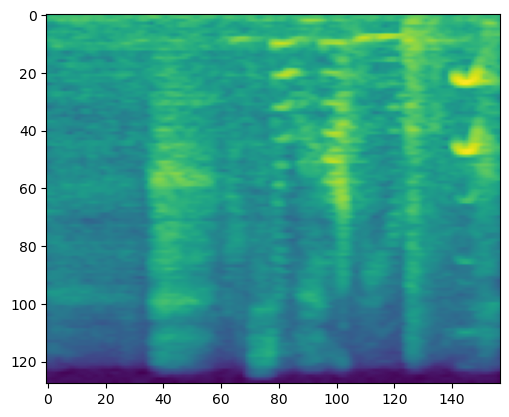

In [8]:
plt.imshow(librosa_spec)

In [9]:
Audio(raw, rate=audio_rate)

In [10]:
Audio(inv_librosa, rate=audio_rate)

### Pool librosa

The inversion takes much longer than generating the spectrogram

In [11]:
for audio_data in audio_data_list:
    process_librosa(audio_data)

Save Raw: 0.001972675323486328
Gen Spec: 0.020797252655029297
Save Raw: 0.0
Gen Spec: 0.014268159866333008
Save Raw: 0.0
Gen Spec: 0.008334159851074219
Save Raw: 0.0009593963623046875
Gen Spec: 0.011488914489746094
Save Raw: 0.0
Gen Spec: 0.0067882537841796875
Save Raw: 0.0
Gen Spec: 0.015634775161743164
Save Raw: 0.0
Gen Spec: 0.015617847442626953
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015630006790161133
Save Raw: 0.0
Gen Spec: 0.015624761581420898
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.016632080078125
Save Raw: 0.0
Gen Spec: 0.015636205673217773
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01563096046447754
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015624761581420898
Save Raw: 0.0


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
C:\Users\LEGION\AppData\Local\Temp\ipykernel_25336\1967138011.py:10: RuntimeWarning: divide by zero encountered in log
  mel_spec = np.log(mel)


Gen Spec: 0.0203704833984375
Save Raw: 0.0014297962188720703
Gen Spec: 0.01206350326538086
Save Raw: 0.0
Gen Spec: 0.008069992065429688
Save Raw: 0.0
Gen Spec: 0.011513233184814453
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015644311904907227
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015625
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015625
Save Raw: 0.0
Gen Spec: 0.03125166893005371
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015623807907104492
Save Raw: 0.0
Gen Spec: 0.0065157413482666016
Save Raw: 0.0
Gen Spec: 0.015642404556274414
Save Raw: 0.0156252384185791
Gen Spec: 0.0064411163330078125
Save Raw: 0.0
Gen Spec: 0.008847236633300781
Save Raw: 0.008006811141967773
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.04032087326049805
Save Raw: 0.0
Gen Spec: 0.015400886535644531
Save Raw: 0.0
Gen Spec: 0.01563286781311035
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015619516372680664
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.015625
Gen Spec: 0.

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1599
  warnings.warn(


Gen Spec: 0.015624046325683594
Save Raw: 0.0
Gen Spec: 0.023482084274291992
Save Raw: 0.0
Gen Spec: 0.020005226135253906
Save Raw: 0.0
Gen Spec: 0.010694026947021484
Save Raw: 0.0
Gen Spec: 0.009407758712768555
Save Raw: 0.0
Gen Spec: 0.010112285614013672
Save Raw: 0.0
Gen Spec: 0.010071277618408203
Save Raw: 0.0
Gen Spec: 0.020195960998535156
Save Raw: 0.0
Gen Spec: 0.010150432586669922
Save Raw: 0.0
Gen Spec: 0.008029699325561523
Save Raw: 0.0
Gen Spec: 0.022562742233276367
Save Raw: 0.0
Gen Spec: 0.0073490142822265625
Save Raw: 0.0
Gen Spec: 0.01009368896484375
Save Raw: 0.0
Gen Spec: 0.010066747665405273
Save Raw: 0.002027750015258789
Gen Spec: 0.008120059967041016
Save Raw: 0.0020296573638916016
Gen Spec: 0.018131732940673828
Save Raw: 0.0015482902526855469
Gen Spec: 0.0188140869140625
Save Raw: 0.0
Gen Spec: 0.011715173721313477
Save Raw: 0.0
Gen Spec: 0.008763790130615234
Save Raw: 0.0
Gen Spec: 0.015641212463378906
Save Raw: 0.0
Gen Spec: 0.015622138977050781
Save Raw: 0.0
Gen 

Gen Spec: 0.016835451126098633
Save Raw: 0.0
Gen Spec: 0.0035767555236816406
Save Raw: 0.0
Gen Spec: 0.04900765419006348
Save Raw: 0.0
Gen Spec: 0.022241592407226562
Save Raw: 0.0
Gen Spec: 0.00513005256652832
Save Raw: 0.0
Gen Spec: 0.013829708099365234
Save Raw: 0.0
Gen Spec: 0.014343738555908203
Save Raw: 0.0
Gen Spec: 0.014784812927246094
Save Raw: 0.0
Gen Spec: 0.0058705806732177734
Save Raw: 0.0
Gen Spec: 0.015630245208740234
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.01592540740966797
Gen Spec: 0.0031576156616210938
Save Raw: 0.0
Gen Spec: 0.0138702392578125
Save Raw: 0.0
Gen Spec: 0.006899118423461914
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.018187284469604492
Save Raw: 0.0
Gen Spec: 0.010054826736450195
Save Raw: 0.0


C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1066
  warnings.warn(


Gen Spec: 0.008066654205322266
Save Raw: 0.002031564712524414
Gen Spec: 0.010120630264282227
Save Raw: 0.0
Gen Spec: 0.018028974533081055
Save Raw: 0.0
Gen Spec: 0.004453420639038086
Save Raw: 0.005524635314941406
Gen Spec: 0.0020875930786132812
Save Raw: 0.0
Gen Spec: 0.01164865493774414
Save Raw: 0.0
Gen Spec: 0.019780635833740234
Save Raw: 0.0
Gen Spec: 0.01719355583190918
Save Raw: 0.0
Gen Spec: 0.015357255935668945
Save Raw: 0.0
Gen Spec: 0.01020669937133789
Save Raw: 0.0
Gen Spec: 0.017178058624267578
Save Raw: 0.0
Gen Spec: 0.010257482528686523
Save Raw: 0.008078813552856445
Gen Spec: 0.022180795669555664
Save Raw: 0.0
Gen Spec: 0.010053396224975586
Save Raw: 0.0
Gen Spec: 0.010097265243530273
Save Raw: 0.0
Gen Spec: 0.03370404243469238
Save Raw: 0.004541873931884766
Gen Spec: 0.009953022003173828
Save Raw: 0.0
Gen Spec: 0.010144472122192383
Save Raw: 0.002031087875366211
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010060548782348633
Save Raw: 0.0
Gen Spec: 0.008373022079467773
Save

C:\Users\LEGION\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=533
  warnings.warn(


Gen Spec: 0.023314237594604492
Save Raw: 0.0009713172912597656
Gen Spec: 0.00800180435180664
Save Raw: 0.00616145133972168
Gen Spec: 0.0015065670013427734
Save Raw: 0.005331754684448242
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.02781844139099121
Save Raw: 0.0
Gen Spec: 0.00677180290222168
Save Raw: 0.0
Gen Spec: 0.01563405990600586
Save Raw: 0.0
Gen Spec: 0.015618562698364258
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015625476837158203
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.013517379760742188
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.019573450088500977
Save Raw: 0.0
Gen Spec: 0.010451078414916992
Save Raw: 0.0
Gen Spec: 0.006843090057373047
Save Raw: 0.0
Gen Spec: 0.01563429832458496
Save Raw: 0.0
Gen Spec: 0.015622377395629883
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.032103538513183594
Save Raw: 0.0
Gen Spec: 0.006452322006225586
Save Raw: 0.0
Gen Spec: 0.008119344711303711
Save Raw: 0.0020096302032470703
Ge

Gen Spec: 0.011104822158813477
Save Raw: 0.0
Gen Spec: 0.01469874382019043
Save Raw: 0.0
Gen Spec: 0.006851673126220703
Save Raw: 0.0
Gen Spec: 0.006436824798583984
Save Raw: 0.0006372928619384766
Gen Spec: 0.013795614242553711
Save Raw: 0.03758096694946289
Gen Spec: 0.011095523834228516
Save Raw: 0.0
Gen Spec: 0.02075672149658203
Save Raw: 0.0
Gen Spec: 0.019323348999023438
Save Raw: 0.0
Gen Spec: 0.01817464828491211
Save Raw: 0.0
Gen Spec: 0.017346858978271484
Save Raw: 0.0
Gen Spec: 0.015156984329223633
Save Raw: 0.0
Gen Spec: 0.012831687927246094
Save Raw: 0.0
Gen Spec: 0.013748645782470703
Save Raw: 0.0019011497497558594
Gen Spec: 0.021355867385864258
Save Raw: 0.0
Gen Spec: 0.009221315383911133
Save Raw: 0.0
Gen Spec: 0.016037702560424805
Save Raw: 0.0
Gen Spec: 0.02122354507446289
Save Raw: 0.0
Gen Spec: 0.00863790512084961
Save Raw: 0.0
Gen Spec: 0.020843029022216797
Save Raw: 0.0
Gen Spec: 0.027827024459838867
Save Raw: 0.0048427581787109375
Gen Spec: 0.0540008544921875
Save R

Gen Spec: 0.06113100051879883
Save Raw: 0.0023691654205322266
Gen Spec: 0.03905820846557617
Save Raw: 0.0
Gen Spec: 0.013953685760498047
Save Raw: 0.0
Gen Spec: 0.020222187042236328
Save Raw: 0.0022101402282714844
Gen Spec: 0.018240690231323242
Save Raw: 0.0
Gen Spec: 0.008840799331665039
Save Raw: 0.005040884017944336
Gen Spec: 0.009151458740234375
Save Raw: 0.0
Gen Spec: 0.013454198837280273
Save Raw: 0.0
Gen Spec: 0.011970281600952148
Save Raw: 0.0
Gen Spec: 0.023013591766357422
Save Raw: 0.0048980712890625
Gen Spec: 0.03023076057434082
Save Raw: 0.0
Gen Spec: 0.011296510696411133
Save Raw: 0.0
Gen Spec: 0.014039754867553711
Save Raw: 0.0
Gen Spec: 0.04169464111328125
Save Raw: 0.0
Gen Spec: 0.01604485511779785
Save Raw: 0.004781484603881836
Gen Spec: 0.00689387321472168
Save Raw: 0.0
Gen Spec: 0.022665739059448242
Save Raw: 0.03983139991760254
Gen Spec: 0.05134081840515137
Save Raw: 0.0
Gen Spec: 0.025074005126953125
Save Raw: 0.002036571502685547
Gen Spec: 0.01694774627685547
Save

Gen Spec: 0.021037578582763672
Save Raw: 0.0
Gen Spec: 0.0044744014739990234
Save Raw: 0.0
Gen Spec: 0.014645814895629883
Save Raw: 0.0
Gen Spec: 0.006813764572143555
Save Raw: 0.00631260871887207
Gen Spec: 0.007619619369506836
Save Raw: 0.0
Gen Spec: 0.01372981071472168
Save Raw: 0.0035130977630615234
Gen Spec: 0.017307281494140625
Save Raw: 0.0
Gen Spec: 0.013877630233764648
Save Raw: 0.0
Gen Spec: 0.020810365676879883
Save Raw: 0.0070798397064208984
Gen Spec: 0.015477180480957031
Save Raw: 0.0
Gen Spec: 0.011695146560668945
Save Raw: 0.0
Gen Spec: 0.0069141387939453125
Save Raw: 0.0022809505462646484
Gen Spec: 0.013298988342285156
Save Raw: 0.0
Gen Spec: 0.026142120361328125
Save Raw: 0.0
Gen Spec: 0.013975381851196289
Save Raw: 0.0
Gen Spec: 0.012860774993896484
Save Raw: 0.0
Gen Spec: 0.012240886688232422
Save Raw: 0.0021867752075195312
Gen Spec: 0.018643856048583984
Save Raw: 0.0
Gen Spec: 0.009146690368652344
Save Raw: 0.0
Gen Spec: 0.007047414779663086
Save Raw: 0.0
Gen Spec: 0

Gen Spec: 0.015311956405639648
Save Raw: 0.0005719661712646484
Gen Spec: 0.0060918331146240234
Save Raw: 0.0
Gen Spec: 0.021117448806762695
Save Raw: 0.0
Gen Spec: 0.015842676162719727
Save Raw: 0.0
Gen Spec: 0.01011347770690918
Save Raw: 0.0
Gen Spec: 0.008037805557250977
Save Raw: 0.0020253658294677734
Gen Spec: 0.0
Save Raw: 0.008068561553955078
Gen Spec: 0.010081291198730469
Save Raw: 0.0020318031311035156
Gen Spec: 0.010103225708007812
Save Raw: 0.0
Gen Spec: 0.020174503326416016
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.008026838302612305
Gen Spec: 0.0020246505737304688
Save Raw: 0.0
Gen Spec: 0.010076522827148438
Save Raw: 0.0
Gen Spec: 0.010046243667602539
Save Raw: 0.0
Gen Spec: 0.020139217376708984
Save Raw: 0.0
Gen Spec: 0.010099172592163086
Save Raw: 0.008034229278564453
Gen Spec: 0.02215433120727539
Save Raw: 0.0
Gen Spec: 0.01335453987121582
Save Raw: 0.0
Gen Spec: 0.008661985397338867
Save Raw: 0.0
Gen Spec: 0.008388042449951172
Save Raw: 0.0
Gen Spec: 0.008054971694946289

Gen Spec: 0.01854395866394043
Save Raw: 0.0
Gen Spec: 0.02187633514404297
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.049851179122924805
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015639543533325195
Save Raw: 0.0
Gen Spec: 0.015622854232788086
Save Raw: 0.0
Gen Spec: 0.006513118743896484
Save Raw: 0.0
Gen Spec: 0.01564311981201172
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.031248092651367188
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015630483627319336
Save Raw: 0.0
Gen Spec: 0.015624046325683594
Save Raw: 0.0
Gen Spec: 0.015625476837158203
Save Raw: 0.0
Gen Spec: 0.011042594909667969
Save Raw: 0.0073091983795166016
Gen Spec: 0.008080482482910156
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015634536743164062
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0312504768371582
Save Raw: 0.0
Gen Spec: 0.015619277954101562
Save Raw: 0.0
Gen Spec: 0.015622138977050781
Save Raw: 0.0
Gen Spec: 0.004129886627197266
Save Raw: 0.042360544204711914
Gen Spec: 0.00812983

Gen Spec: 0.02878260612487793
Save Raw: 0.002039670944213867
Gen Spec: 0.020020723342895508
Save Raw: 0.0
Gen Spec: 0.010052919387817383
Save Raw: 0.0
Gen Spec: 0.02036309242248535
Save Raw: 0.0
Gen Spec: 0.020200490951538086
Save Raw: 0.0
Gen Spec: 0.010092973709106445
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010060310363769531
Save Raw: 0.0
Gen Spec: 0.02013683319091797
Save Raw: 0.0
Gen Spec: 0.010084152221679688
Save Raw: 0.0
Gen Spec: 0.010095834732055664
Save Raw: 0.0
Gen Spec: 0.010098695755004883
Save Raw: 0.0
Gen Spec: 0.01005101203918457
Save Raw: 0.0
Gen Spec: 0.018130064010620117
Save Raw: 0.0020303726196289062
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.0201718807220459
Save Raw: 0.0
Gen Spec: 0.010088682174682617
Save Raw: 0.008034944534301758
Gen Spec: 0.002023458480834961
Save Raw: 0.0
Gen Spec: 0.01008462905883789
Save Raw: 0.0010371208190917969
Gen Spec: 0.00932002067565918
Save Raw: 0.0068836212158203125
Gen Spec: 0.0030548572540283203
Save Raw: 0.0
Gen Spec

Gen Spec: 0.011463403701782227
Save Raw: 0.0
Gen Spec: 0.009225130081176758
Save Raw: 0.0
Gen Spec: 0.018053770065307617
Save Raw: 0.0
Gen Spec: 0.008070230484008789
Save Raw: 0.0
Gen Spec: 0.015627145767211914
Save Raw: 0.0
Gen Spec: 0.01562809944152832
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01562356948852539
Save Raw: 0.0
Gen Spec: 0.015625476837158203
Save Raw: 0.0
Gen Spec: 0.015625
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01613616943359375
Save Raw: 0.0
Gen Spec: 0.020193099975585938
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.008043527603149414
Gen Spec: 0.0324397087097168
Save Raw: 0.0
Gen Spec: 0.03959989547729492
Save Raw: 0.00106048583984375
Gen Spec: 0.0201718807220459
Save Raw: 0.0
Gen Spec: 0.010080337524414062
Save Raw: 0.0
Gen Spec: 0.020232200622558594
Save Raw: 0.0
Gen Spec: 0.020212650299072266
Save Raw: 0.0
Gen Spec: 0.010112285614013672
Save Raw: 0.0
Gen Spec: 0.010278701782226562
Save Raw: 0.0
Gen Spec: 0.010129451751708984
Save Raw: 0.0
Gen

Gen Spec: 0.01740860939025879
Save Raw: 0.002613544464111328
Gen Spec: 0.03258633613586426
Save Raw: 0.0
Gen Spec: 0.008718490600585938
Save Raw: 0.0
Gen Spec: 0.021758079528808594
Save Raw: 0.0
Gen Spec: 0.02023005485534668
Save Raw: 0.0
Gen Spec: 0.020201921463012695
Save Raw: 0.0
Gen Spec: 0.010123729705810547
Save Raw: 0.0
Gen Spec: 0.010141849517822266
Save Raw: 0.0
Gen Spec: 0.0020742416381835938
Save Raw: 0.008064746856689453
Gen Spec: 0.002060413360595703
Save Raw: 0.0
Gen Spec: 0.010082006454467773
Save Raw: 0.0
Gen Spec: 0.01011514663696289
Save Raw: 0.0
Gen Spec: 0.018191099166870117
Save Raw: 0.0020210742950439453
Gen Spec: 0.023452043533325195
Save Raw: 0.03691506385803223
Gen Spec: 0.01819133758544922
Save Raw: 0.00202178955078125
Gen Spec: 0.018167972564697266
Save Raw: 0.0
Gen Spec: 0.002035379409790039
Save Raw: 0.0
Gen Spec: 0.020306110382080078
Save Raw: 0.0
Gen Spec: 0.020217180252075195
Save Raw: 0.00805807113647461
Gen Spec: 0.02217698097229004
Save Raw: 0.0
Gen S

Save Raw: 0.00811457633972168
Gen Spec: 0.016588687896728516
Save Raw: 0.003313302993774414
Gen Spec: 0.00857996940612793
Save Raw: 0.002009868621826172
Gen Spec: 0.012579917907714844
Save Raw: 0.0
Gen Spec: 0.010189294815063477
Save Raw: 0.0
Gen Spec: 0.012598752975463867
Save Raw: 0.0
Gen Spec: 0.007593393325805664
Save Raw: 0.0
Gen Spec: 0.020373821258544922
Save Raw: 0.0
Gen Spec: 0.010122299194335938
Save Raw: 0.0
Gen Spec: 0.010097265243530273
Save Raw: 0.00808095932006836
Gen Spec: 0.010115861892700195
Save Raw: 0.0
Gen Spec: 0.012181758880615234
Save Raw: 0.0
Gen Spec: 0.010118961334228516
Save Raw: 0.0
Gen Spec: 0.018159151077270508
Save Raw: 0.0
Gen Spec: 0.0303192138671875
Save Raw: 0.0
Gen Spec: 0.002978086471557617
Save Raw: 0.0
Gen Spec: 0.053555965423583984
Save Raw: 0.0
Gen Spec: 0.006094455718994141
Save Raw: 0.0
Gen Spec: 0.018182754516601562
Save Raw: 0.0
Gen Spec: 0.022153615951538086
Save Raw: 0.0
Gen Spec: 0.02023148536682129
Save Raw: 0.0
Gen Spec: 0.010088682174

Gen Spec: 0.01829814910888672
Save Raw: 0.002228975296020508
Gen Spec: 0.003064393997192383
Save Raw: 0.0
Gen Spec: 0.0073926448822021484
Save Raw: 0.0
Gen Spec: 0.009614229202270508
Save Raw: 0.0
Gen Spec: 0.010068178176879883
Save Raw: 0.0
Gen Spec: 0.02025890350341797
Save Raw: 0.0
Gen Spec: 0.02026677131652832
Save Raw: 0.0
Gen Spec: 0.010106801986694336
Save Raw: 0.0
Gen Spec: 0.008033037185668945
Save Raw: 0.0
Gen Spec: 0.012095212936401367
Save Raw: 0.0
Gen Spec: 0.008067131042480469
Save Raw: 0.0020296573638916016
Gen Spec: 0.008083343505859375
Save Raw: 0.0
Gen Spec: 0.002034425735473633
Save Raw: 0.0
Gen Spec: 0.0181276798248291
Save Raw: 0.0020520687103271484
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010106086730957031
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010101079940795898
Save Raw: 0.008031845092773438
Gen Spec: 0.002050161361694336
Save Raw: 0.0
Gen Spec: 0.01009988784790039
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 2.8133392333984375e-05
Gen Spec: 0.0020382404

Gen Spec: 0.022009611129760742
Save Raw: 0.0
Gen Spec: 0.01661515235900879
Save Raw: 0.0
Gen Spec: 0.0028777122497558594
Save Raw: 0.0
Gen Spec: 0.019162654876708984
Save Raw: 0.008081436157226562
Gen Spec: 0.02014946937561035
Save Raw: 0.0
Gen Spec: 0.002024412155151367
Save Raw: 0.0
Gen Spec: 0.020137310028076172
Save Raw: 0.0
Gen Spec: 0.010077953338623047
Save Raw: 0.0
Gen Spec: 0.01012563705444336
Save Raw: 0.0
Gen Spec: 0.010061502456665039
Save Raw: 0.0
Gen Spec: 0.020155906677246094
Save Raw: 0.0
Gen Spec: 0.018140554428100586
Save Raw: 0.002025127410888672
Gen Spec: 0.02825188636779785
Save Raw: 0.002032041549682617
Gen Spec: 0.010053873062133789
Save Raw: 0.0
Gen Spec: 0.029993534088134766
Save Raw: 0.0
Gen Spec: 0.038356781005859375
Save Raw: 0.0
Gen Spec: 0.022173404693603516
Save Raw: 0.0
Gen Spec: 0.020160198211669922
Save Raw: 0.0
Gen Spec: 0.008059263229370117
Save Raw: 0.0020482540130615234
Gen Spec: 0.0201723575592041
Save Raw: 0.0
Gen Spec: 0.010068416595458984
Save 

Gen Spec: 0.011371135711669922
Save Raw: 0.0
Gen Spec: 0.009153366088867188
Save Raw: 0.0
Gen Spec: 0.020099401473999023
Save Raw: 0.0
Gen Spec: 0.0302736759185791
Save Raw: 0.0
Gen Spec: 0.01009988784790039
Save Raw: 0.0
Gen Spec: 0.010061979293823242
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.008009910583496094
Gen Spec: 0.0022602081298828125
Save Raw: 0.0
Gen Spec: 0.010070323944091797
Save Raw: 0.00800776481628418
Gen Spec: 0.002088785171508789
Save Raw: 0.0
Gen Spec: 0.010077238082885742
Save Raw: 0.0
Gen Spec: 0.010118484497070312
Save Raw: 0.0
Gen Spec: 0.01006174087524414
Save Raw: 0.0
Gen Spec: 0.010172367095947266
Save Raw: 0.0
Gen Spec: 0.01682114601135254
Save Raw: 0.0
Gen Spec: 0.007185697555541992
Save Raw: 0.0
Gen Spec: 0.007207632064819336
Save Raw: 0.0
Gen Spec: 0.007531404495239258
Save Raw: 0.0020296573638916016
Gen Spec: 0.010082244873046875
Save Raw: 0.0
Gen Spec: 0.008032083511352539
Save Raw: 0.0
Gen Spec: 0.010100603103637695
Save Raw: 0.0
Gen Spec: 0.0158371925354

Gen Spec: 0.01155853271484375
Save Raw: 0.0
Gen Spec: 0.006963491439819336
Save Raw: 0.0
Gen Spec: 0.013619422912597656
Save Raw: 0.0
Gen Spec: 0.008597373962402344
Save Raw: 0.0
Gen Spec: 0.010219097137451172
Save Raw: 0.0
Gen Spec: 0.020193099975585938
Save Raw: 0.0
Gen Spec: 0.020157575607299805
Save Raw: 0.0
Gen Spec: 0.010066032409667969
Save Raw: 0.0
Gen Spec: 0.010097503662109375
Save Raw: 0.0
Gen Spec: 0.02016901969909668
Save Raw: 0.0
Gen Spec: 0.010056734085083008
Save Raw: 0.0
Gen Spec: 0.010093927383422852
Save Raw: 0.0
Gen Spec: 0.010084152221679688
Save Raw: 0.0
Gen Spec: 0.0020928382873535156
Save Raw: 0.0
Gen Spec: 0.03024005889892578
Save Raw: 0.0
Gen Spec: 0.018134117126464844
Save Raw: 0.002028942108154297
Gen Spec: 0.02009725570678711
Save Raw: 0.004824161529541016
Gen Spec: 0.005087375640869141
Save Raw: 0.0
Gen Spec: 0.018178462982177734
Save Raw: 0.0020728111267089844
Gen Spec: 0.010118961334228516
Save Raw: 0.0
Gen Spec: 0.01016092300415039
Save Raw: 0.0
Gen Spe

Gen Spec: 0.030327320098876953
Save Raw: 0.002704143524169922
Gen Spec: 0.01801133155822754
Save Raw: 0.0
Gen Spec: 0.020191192626953125
Save Raw: 0.0
Gen Spec: 0.03046250343322754
Save Raw: 0.0
Gen Spec: 0.010111570358276367
Save Raw: 0.0
Gen Spec: 0.010058164596557617
Save Raw: 0.0
Gen Spec: 0.010113954544067383
Save Raw: 0.0
Gen Spec: 0.020183086395263672
Save Raw: 0.0
Gen Spec: 0.010058164596557617
Save Raw: 0.0
Gen Spec: 0.01812267303466797
Save Raw: 0.0
Gen Spec: 0.012148857116699219
Save Raw: 0.0
Gen Spec: 0.01806473731994629
Save Raw: 8.225440979003906e-05
Gen Spec: 0.012117862701416016
Save Raw: 0.0
Gen Spec: 0.03259420394897461
Save Raw: 0.0
Gen Spec: 0.008127689361572266
Save Raw: 0.0
Gen Spec: 0.010097265243530273
Save Raw: 0.0
Gen Spec: 0.020148277282714844
Save Raw: 0.0
Gen Spec: 0.020216703414916992
Save Raw: 0.0
Gen Spec: 0.010058164596557617
Save Raw: 0.0
Gen Spec: 0.010102033615112305
Save Raw: 0.0
Gen Spec: 0.010078191757202148
Save Raw: 0.0
Gen Spec: 0.0101277828216

Save Raw: 0.008074760437011719
Gen Spec: 0.0320286750793457
Save Raw: 0.008080720901489258
Gen Spec: 0.022485733032226562
Save Raw: 0.0
Gen Spec: 0.03026270866394043
Save Raw: 0.0
Gen Spec: 0.010128021240234375
Save Raw: 0.0
Gen Spec: 0.018221139907836914
Save Raw: 0.0
Gen Spec: 0.0020568370819091797
Save Raw: 0.0
Gen Spec: 0.02014470100402832
Save Raw: 0.0
Gen Spec: 0.010135173797607422
Save Raw: 0.0
Gen Spec: 0.010046005249023438
Save Raw: 0.0
Gen Spec: 0.010163545608520508
Save Raw: 0.0
Gen Spec: 0.030305862426757812
Save Raw: 0.0
Gen Spec: 0.008063793182373047
Save Raw: 0.0
Gen Spec: 0.037123918533325195
Save Raw: 0.0010190010070800781
Gen Spec: 0.007171154022216797
Save Raw: 0.0010576248168945312
Gen Spec: 0.007704496383666992
Save Raw: 0.0010230541229248047
Gen Spec: 0.018396377563476562
Save Raw: 0.0
Gen Spec: 0.018201112747192383
Save Raw: 0.0
Gen Spec: 0.002026796340942383
Save Raw: 0.0
Gen Spec: 0.030368328094482422
Save Raw: 0.0
Gen Spec: 0.018209218978881836
Save Raw: 0.0
G

Save Raw: 0.042999982833862305
Gen Spec: 0.03808736801147461
Save Raw: 0.0
Gen Spec: 0.01006627082824707
Save Raw: 0.0
Gen Spec: 0.020258188247680664
Save Raw: 0.0
Gen Spec: 0.0302581787109375
Save Raw: 0.0
Gen Spec: 0.008072853088378906
Save Raw: 0.0
Gen Spec: 0.0020258426666259766
Save Raw: 0.0
Gen Spec: 0.020281314849853516
Save Raw: 0.0
Gen Spec: 0.018222332000732422
Save Raw: 0.0
Gen Spec: 0.020217180252075195
Save Raw: 0.0
Gen Spec: 0.002024412155151367
Save Raw: 0.0
Gen Spec: 0.008056163787841797
Save Raw: 0.0020275115966796875
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.020157814025878906
Save Raw: 0.0
Gen Spec: 0.018209218978881836
Save Raw: 0.002028942108154297
Gen Spec: 0.004946231842041016
Save Raw: 0.0
Gen Spec: 0.006065845489501953
Save Raw: 0.0
Gen Spec: 0.008895635604858398
Save Raw: 0.0
Gen Spec: 0.020204544067382812
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010074615478515625
Save Raw: 0.0
Gen Spec: 0.01812291145324707
Save Raw: 0.0
Gen Spec: 0.002026319503784

Gen Spec: 0.02232837677001953
Save Raw: 0.0
Gen Spec: 0.024735212326049805
Save Raw: 0.0
Gen Spec: 0.030246973037719727
Save Raw: 0.0
Gen Spec: 0.010122537612915039
Save Raw: 0.008040666580200195
Gen Spec: 0.0020351409912109375
Save Raw: 0.0
Gen Spec: 0.01012420654296875
Save Raw: 0.0
Gen Spec: 0.02017831802368164
Save Raw: 0.0
Gen Spec: 0.030348539352416992
Save Raw: 0.0
Gen Spec: 0.030320405960083008
Save Raw: 0.0
Gen Spec: 0.010120391845703125
Save Raw: 0.0
Gen Spec: 0.01013040542602539
Save Raw: 0.008037567138671875
Gen Spec: 0.0020656585693359375
Save Raw: 0.0
Gen Spec: 0.014355659484863281
Save Raw: 0.0022132396697998047
Gen Spec: 0.023939847946166992
Save Raw: 0.008038759231567383
Gen Spec: 0.002053976058959961
Save Raw: 0.0
Gen Spec: 0.010079145431518555
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.008028268814086914
Gen Spec: 0.002024412155151367
Save Raw: 0.0
Gen Spec: 0.01820683479309082
Save Raw: 0.0
Gen Spec: 0.030383586883544922
Save Raw: 0.0020377635955810547
Gen Spec: 0.0302

Gen Spec: 0.019318580627441406
Save Raw: 0.0
Gen Spec: 0.021626949310302734
Save Raw: 0.0
Gen Spec: 0.023688793182373047
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015625715255737305
Save Raw: 0.0
Gen Spec: 0.015619516372680664
Save Raw: 0.0
Gen Spec: 0.015631914138793945
Save Raw: 0.0
Gen Spec: 0.010513544082641602
Save Raw: 0.0
Gen Spec: 0.0156400203704834
Save Raw: 0.0
Gen Spec: 0.01563262939453125
Save Raw: 0.0
Gen Spec: 0.015625
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.03124833106994629
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.02213263511657715
Save Raw: 0.0
Gen Spec: 0.027284622192382812
Save Raw: 0.0
Gen Spec: 0.006392002105712891
Save Raw: 0.0
Gen Spec: 0.015376806259155273
Save Raw: 0.0
Gen Spec: 0.01563429832458496
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01561880111694336
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.015625
Save Raw: 0.0
Gen Spec: 0.004017353057861328
Save Raw: 0.0
Gen Spec: 0.015643596649169922
Save 

Gen Spec: 0.013736963272094727
Save Raw: 0.0
Gen Spec: 0.006765604019165039
Save Raw: 0.0006053447723388672
Gen Spec: 0.0020377635955810547
Save Raw: 0.0
Gen Spec: 0.03027200698852539
Save Raw: 0.0
Gen Spec: 0.010064125061035156
Save Raw: 0.0
Gen Spec: 0.02014756202697754
Save Raw: 0.0
Gen Spec: 0.010116815567016602
Save Raw: 0.0
Gen Spec: 0.010126352310180664
Save Raw: 0.0
Gen Spec: 0.010131597518920898
Save Raw: 0.0
Gen Spec: 0.01011204719543457
Save Raw: 0.03789043426513672
Gen Spec: 0.013167858123779297
Save Raw: 0.0
Gen Spec: 0.010129928588867188
Save Raw: 0.0
Gen Spec: 0.008057832717895508
Save Raw: 0.0
Gen Spec: 0.002067089080810547
Save Raw: 0.0
Gen Spec: 0.010093927383422852
Save Raw: 0.0
Gen Spec: 0.014040708541870117
Save Raw: 0.0
Gen Spec: 0.014349222183227539
Save Raw: 0.002057790756225586
Gen Spec: 0.04043769836425781
Save Raw: 0.008065938949584961
Gen Spec: 0.012179851531982422
Save Raw: 0.0
Gen Spec: 0.010129690170288086
Save Raw: 0.0
Gen Spec: 0.010074377059936523
Save

Gen Spec: 0.03249073028564453
Save Raw: 0.0
Gen Spec: 0.012341022491455078
Save Raw: 0.0
Gen Spec: 0.015928983688354492
Save Raw: 0.0
Gen Spec: 0.022215604782104492
Save Raw: 0.0
Gen Spec: 0.018211841583251953
Save Raw: 0.0
Gen Spec: 0.0020530223846435547
Save Raw: 0.0
Gen Spec: 0.018146514892578125
Save Raw: 0.0
Gen Spec: 0.027312755584716797
Save Raw: 0.0010256767272949219
Gen Spec: 0.012208223342895508
Save Raw: 0.0020072460174560547
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01815485954284668
Save Raw: 0.0
Gen Spec: 0.012140512466430664
Save Raw: 0.0
Gen Spec: 0.008031129837036133
Save Raw: 0.002054929733276367
Gen Spec: 0.010114908218383789
Save Raw: 0.0
Gen Spec: 0.008026123046875
Save Raw: 0.0
Gen Spec: 0.042188167572021484
Save Raw: 0.0
Gen Spec: 0.010085821151733398
Save Raw: 0.0
Gen Spec: 0.010095357894897461
Save Raw: 0.0
Gen Spec: 0.01012420654296875
Save Raw: 0.0
Gen Spec: 0.0201566219329834
Save Raw: 0.0
Gen Spec: 0.010113000869750977
Save Raw: 0.0
Gen Spec: 0.01005411148071

Gen Spec: 0.02002263069152832
Save Raw: 0.0010297298431396484
Gen Spec: 0.00751805305480957
Save Raw: 0.0
Gen Spec: 0.0067822933197021484
Save Raw: 0.0010213851928710938
Gen Spec: 0.006174564361572266
Save Raw: 0.0
Gen Spec: 0.008096694946289062
Save Raw: 0.0
Gen Spec: 0.018111467361450195
Save Raw: 0.0
Gen Spec: 0.012115478515625
Save Raw: 0.0
Gen Spec: 0.010052680969238281
Save Raw: 0.0
Gen Spec: 0.020137310028076172
Save Raw: 0.0
Gen Spec: 0.01013493537902832
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010114431381225586
Save Raw: 0.0
Gen Spec: 0.010091066360473633
Save Raw: 0.0
Gen Spec: 0.010049581527709961
Save Raw: 0.0
Gen Spec: 0.010099172592163086
Save Raw: 0.0
Gen Spec: 0.010108709335327148
Save Raw: 0.008078336715698242
Gen Spec: 0.0489497184753418
Save Raw: 0.00015664100646972656
Gen Spec: 0.012143135070800781
Save Raw: 8.368492126464844e-05
Gen Spec: 0.009963035583496094
Save Raw: 0.0
Gen Spec: 0.010139703750610352
Save Raw: 0.0
Gen Spec: 0.010134220123291016
Sav

Gen Spec: 0.011582374572753906
Save Raw: 0.0
Gen Spec: 0.039026737213134766
Save Raw: 0.0
Gen Spec: 0.010119438171386719
Save Raw: 0.0
Gen Spec: 0.02016139030456543
Save Raw: 0.0
Gen Spec: 0.03029775619506836
Save Raw: 0.0
Gen Spec: 0.02825641632080078
Save Raw: 0.0
Gen Spec: 0.012103796005249023
Save Raw: 0.0
Gen Spec: 0.010147571563720703
Save Raw: 0.0
Gen Spec: 0.01006627082824707
Save Raw: 0.0
Gen Spec: 0.020182132720947266
Save Raw: 0.0
Gen Spec: 0.008727312088012695
Save Raw: 0.0015368461608886719
Gen Spec: 0.026971101760864258
Save Raw: 0.0018842220306396484
Gen Spec: 0.011859893798828125
Save Raw: 0.0020732879638671875
Gen Spec: 0.008075714111328125
Save Raw: 0.0
Gen Spec: 0.02015519142150879
Save Raw: 0.0
Gen Spec: 0.01813054084777832
Save Raw: 0.0020322799682617188
Gen Spec: 0.018113374710083008
Save Raw: 0.002023935317993164
Gen Spec: 0.020146608352661133
Save Raw: 0.0
Gen Spec: 0.010110855102539062
Save Raw: 0.0
Gen Spec: 0.018145084381103516
Save Raw: 0.0020232200622558594

Gen Spec: 0.02840900421142578
Save Raw: 0.002321481704711914
Gen Spec: 0.02037835121154785
Save Raw: 0.0
Gen Spec: 0.010066986083984375
Save Raw: 0.0
Gen Spec: 0.020151615142822266
Save Raw: 0.0
Gen Spec: 0.010129213333129883
Save Raw: 0.0
Gen Spec: 0.07857131958007812
Save Raw: 0.0
Gen Spec: 0.010063886642456055
Save Raw: 0.0
Gen Spec: 0.012117385864257812
Save Raw: 0.0
Gen Spec: 0.010054826736450195
Save Raw: 0.0
Gen Spec: 0.05045771598815918
Save Raw: 0.0
Gen Spec: 0.010111331939697266
Save Raw: 0.0
Gen Spec: 0.020163774490356445
Save Raw: 0.0
Gen Spec: 0.020166397094726562
Save Raw: 0.0
Gen Spec: 0.02017521858215332
Save Raw: 0.0
Gen Spec: 0.038283586502075195
Save Raw: 0.0
Gen Spec: 0.01006627082824707
Save Raw: 0.002023458480834961
Gen Spec: 0.020163536071777344
Save Raw: 0.00812220573425293
Gen Spec: 0.022159337997436523
Save Raw: 0.0
Gen Spec: 0.010056495666503906
Save Raw: 0.0
Gen Spec: 0.04056954383850098
Save Raw: 0.0
Gen Spec: 0.013471126556396484
Save Raw: 0.0
Gen Spec: 0.

Gen Spec: 0.02390432357788086
Save Raw: 0.0026671886444091797
Gen Spec: 0.011996746063232422
Save Raw: 0.0
Gen Spec: 0.010021448135375977
Save Raw: 0.0
Gen Spec: 0.012084722518920898
Save Raw: 0.0
Gen Spec: 0.03026556968688965
Save Raw: 0.0
Gen Spec: 0.010061025619506836
Save Raw: 0.0
Gen Spec: 0.018143653869628906
Save Raw: 0.0
Gen Spec: 0.012125730514526367
Save Raw: 0.0
Gen Spec: 0.010067224502563477
Save Raw: 0.0
Gen Spec: 0.020149707794189453
Save Raw: 0.0
Gen Spec: 0.010093450546264648
Save Raw: 0.008027315139770508
Gen Spec: 0.010088443756103516
Save Raw: 0.0
Gen Spec: 0.022214889526367188
Save Raw: 0.0
Gen Spec: 0.02408742904663086
Save Raw: 0.0
Gen Spec: 0.016873836517333984
Save Raw: 0.0
Gen Spec: 0.017633914947509766
Save Raw: 0.0
Gen Spec: 0.0020253658294677734
Save Raw: 0.0
Gen Spec: 0.010107278823852539
Save Raw: 0.0
Gen Spec: 0.010058164596557617
Save Raw: 0.0
Gen Spec: 0.02024078369140625
Save Raw: 0.0
Gen Spec: 0.020245790481567383
Save Raw: 0.0
Gen Spec: 0.00810003280

Save Raw: 0.008060693740844727
Gen Spec: 0.016754627227783203
Save Raw: 0.0
Gen Spec: 0.0072078704833984375
Save Raw: 0.006564140319824219
Gen Spec: 0.002033710479736328
Save Raw: 0.0
Gen Spec: 0.03038167953491211
Save Raw: 0.0
Gen Spec: 0.010082721710205078
Save Raw: 0.0
Gen Spec: 0.030394554138183594
Save Raw: 0.0
Gen Spec: 0.010125398635864258
Save Raw: 0.0
Gen Spec: 0.02021646499633789
Save Raw: 0.0
Gen Spec: 0.010082483291625977
Save Raw: 0.0
Gen Spec: 0.01815176010131836
Save Raw: 0.0
Gen Spec: 0.012089252471923828
Save Raw: 0.0
Gen Spec: 0.020164966583251953
Save Raw: 0.0
Gen Spec: 0.017404794692993164
Save Raw: 0.0005271434783935547
Gen Spec: 0.010107755661010742
Save Raw: 0.0020284652709960938
Gen Spec: 0.020125865936279297
Save Raw: 0.0
Gen Spec: 0.010129928588867188
Save Raw: 0.0
Gen Spec: 0.020223140716552734
Save Raw: 0.0
Gen Spec: 0.010046243667602539
Save Raw: 0.0
Gen Spec: 0.0302426815032959
Save Raw: 0.0
Gen Spec: 0.010048389434814453
Save Raw: 0.0
Gen Spec: 0.02821326

Gen Spec: 0.032445430755615234
Save Raw: 0.0
Gen Spec: 0.05053234100341797
Save Raw: 0.0
Gen Spec: 0.03834033012390137
Save Raw: 0.0
Gen Spec: 0.03491330146789551
Save Raw: 0.0010406970977783203
Gen Spec: 0.03745222091674805
Save Raw: 0.0
Gen Spec: 0.05214643478393555
Save Raw: 0.0
Gen Spec: 0.029052019119262695
Save Raw: 0.0
Gen Spec: 0.010320663452148438
Save Raw: 0.0
Gen Spec: 0.010143756866455078
Save Raw: 0.008087396621704102
Gen Spec: 0.0505216121673584
Save Raw: 0.002060413360595703
Gen Spec: 0.01011967658996582
Save Raw: 0.0
Gen Spec: 0.010063409805297852
Save Raw: 0.04056096076965332
Gen Spec: 0.0297853946685791
Save Raw: 0.0
Gen Spec: 0.02141427993774414
Save Raw: 0.0
Gen Spec: 0.016899585723876953
Save Raw: 0.0
Gen Spec: 0.040567636489868164
Save Raw: 0.0020601749420166016
Gen Spec: 0.020267486572265625
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.008063793182373047
Gen Spec: 0.0020263195037841797
Save Raw: 0.0
Gen Spec: 0.010123014450073242
Save Raw: 0.0
Gen Spec: 0.008062362670

Gen Spec: 0.010099172592163086
Save Raw: 0.0
Gen Spec: 0.010169029235839844
Save Raw: 0.0
Gen Spec: 0.02198314666748047
Save Raw: 0.0
Gen Spec: 0.010072708129882812
Save Raw: 0.0
Gen Spec: 0.03029632568359375
Save Raw: 0.0
Gen Spec: 0.0302426815032959
Save Raw: 0.0
Gen Spec: 0.02022075653076172
Save Raw: 0.0
Gen Spec: 0.008071422576904297
Save Raw: 0.0
Gen Spec: 0.03230738639831543
Save Raw: 0.0
Gen Spec: 0.020377159118652344
Save Raw: 0.0
Gen Spec: 0.01009511947631836
Save Raw: 0.0
Gen Spec: 0.010044097900390625
Save Raw: 0.0
Gen Spec: 0.020355701446533203
Save Raw: 0.0
Gen Spec: 0.02037191390991211
Save Raw: 0.008064031600952148
Gen Spec: 0.002056598663330078
Save Raw: 0.0
Gen Spec: 0.020289897918701172
Save Raw: 0.0
Gen Spec: 0.010101556777954102
Save Raw: 0.0
Gen Spec: 0.010116338729858398
Save Raw: 0.0
Gen Spec: 0.020251035690307617
Save Raw: 0.0
Gen Spec: 0.010094404220581055
Save Raw: 0.0
Gen Spec: 0.010112524032592773
Save Raw: 0.00807642936706543
Gen Spec: 0.002053499221801758

Gen Spec: 0.03827714920043945
Save Raw: 0.0
Gen Spec: 0.008645057678222656
Save Raw: 0.0
Gen Spec: 0.0034856796264648438
Save Raw: 0.0
Gen Spec: 0.008118152618408203
Save Raw: 0.002027750015258789
Gen Spec: 0.0033082962036132812
Save Raw: 0.0045108795166015625
Gen Spec: 0.012167692184448242
Save Raw: 0.0
Gen Spec: 0.010054588317871094
Save Raw: 0.0
Gen Spec: 0.0302431583404541
Save Raw: 0.0
Gen Spec: 0.010068655014038086
Save Raw: 0.0
Gen Spec: 0.028322696685791016
Save Raw: 0.0020301342010498047
Gen Spec: 0.010074138641357422
Save Raw: 0.0
Gen Spec: 0.018149852752685547
Save Raw: 0.0020215511322021484
Gen Spec: 0.010095834732055664
Save Raw: 0.00802755355834961
Gen Spec: 0.02225661277770996
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.017946243286132812
Save Raw: 0.0087127685546875
Gen Spec: 0.02383112907409668
Save Raw: 0.0
Gen Spec: 0.010062456130981445
Save Raw: 0.0
Gen Spec: 0.020177841186523438
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.01010894775390625
Save 

Gen Spec: 0.020148277282714844
Save Raw: 0.0
Gen Spec: 0.010243892669677734
Save Raw: 0.0
Gen Spec: 0.010339975357055664
Save Raw: 0.0
Gen Spec: 0.0202176570892334
Save Raw: 0.0
Gen Spec: 0.010110139846801758
Save Raw: 0.0
Gen Spec: 0.01815509796142578
Save Raw: 0.0
Gen Spec: 0.0020334720611572266
Save Raw: 0.0
Gen Spec: 0.010069131851196289
Save Raw: 0.0
Gen Spec: 0.008080005645751953
Save Raw: 0.0
Gen Spec: 0.012105226516723633
Save Raw: 0.008067607879638672
Gen Spec: 0.002056598663330078
Save Raw: 0.0
Gen Spec: 0.018185138702392578
Save Raw: 0.0
Gen Spec: 0.012100458145141602
Save Raw: 0.0
Gen Spec: 0.020198583602905273
Save Raw: 0.0
Gen Spec: 0.010097265243530273
Save Raw: 0.0
Gen Spec: 0.02020096778869629
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.008031368255615234
Gen Spec: 0.002056121826171875
Save Raw: 0.0
Gen Spec: 0.0200345516204834
Save Raw: 0.0
Gen Spec: 0.017951011657714844
Save Raw: 0.002028226852416992
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.018139123916625977
Save Raw: 0.

Gen Spec: 0.020320653915405273
Save Raw: 0.0
Gen Spec: 0.02037358283996582
Save Raw: 0.0
Gen Spec: 0.015855073928833008
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.015999555587768555
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.016000986099243164
Save Raw: 0.0
Gen Spec: 0.03999924659729004
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.016004562377929688
Save Raw: 0.0
Gen Spec: 0.02400040626525879
Save Raw: 0.0
Gen Spec: 0.023994922637939453
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.018421411514282227
Save Raw: 0.0
Gen Spec: 0.004702568054199219
Save Raw: 0.0
Gen Spec: 0.010074377059936523
Save Raw: 0.0
Gen Spec: 0.002056121826171875
Save Raw: 0.0
Gen Spec: 0.02024388313293457
Save Raw: 0.0
Gen Spec: 0.008069276809692383
Save Raw: 0.002038717269897461
Gen Spec: 0.0
Save Raw: 0.0
Gen Spec: 0.010114431381225586
Save Raw: 0.0
Gen Spec: 0.01009678840637207
Save Raw: 0.0
Gen Spec: 0.0180

Gen Spec: 0.030231237411499023
Save Raw: 0.0
Gen Spec: 0.028099775314331055
Save Raw: 0.0
Gen Spec: 0.012192010879516602
Save Raw: 0.0
Gen Spec: 0.010120391845703125
Save Raw: 0.0
Gen Spec: 0.018208980560302734
Save Raw: 0.0020606517791748047
Gen Spec: 0.010132551193237305
Save Raw: 0.0
Gen Spec: 0.02024555206298828
Save Raw: 0.0
Gen Spec: 0.020195960998535156
Save Raw: 0.0
Gen Spec: 0.03024601936340332
Save Raw: 0.0
Gen Spec: 0.03035759925842285
Save Raw: 0.0
Gen Spec: 0.02828216552734375
Save Raw: 0.0
Gen Spec: 0.010188579559326172
Save Raw: 0.0
Gen Spec: 0.012164115905761719
Save Raw: 0.0
Gen Spec: 0.030009031295776367
Save Raw: 0.0
Gen Spec: 0.02021050453186035
Save Raw: 0.0
Gen Spec: 0.010105609893798828
Save Raw: 0.0
Gen Spec: 0.02024531364440918
Save Raw: 0.0
Gen Spec: 0.010128259658813477
Save Raw: 0.0
Gen Spec: 0.010136842727661133
Save Raw: 0.0
Gen Spec: 0.010116100311279297
Save Raw: 0.0
Gen Spec: 0.010081052780151367
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 0.00806093215942382

Gen Spec: 0.05109405517578125
Save Raw: 0.0
Gen Spec: 0.010131120681762695
Save Raw: 0.0
Gen Spec: 0.01006007194519043
Save Raw: 0.0
Gen Spec: 0.0
Save Raw: 7.200241088867188e-05
Gen Spec: 0.04232668876647949
Save Raw: 0.0
Gen Spec: 0.028184175491333008
Save Raw: 0.0
Gen Spec: 0.02020096778869629
Save Raw: 0.0020546913146972656
Gen Spec: 0.010082483291625977
Save Raw: 0.0
Gen Spec: 0.02019524574279785
Save Raw: 0.0
Gen Spec: 0.020247697830200195
Save Raw: 0.0
Gen Spec: 0.028288841247558594
Save Raw: 0.0020494461059570312
Gen Spec: 0.10138249397277832
Save Raw: 0.0
Gen Spec: 0.03832697868347168
Save Raw: 0.0020263195037841797
Gen Spec: 0.048354148864746094
Save Raw: 0.0
Gen Spec: 0.002022266387939453
Save Raw: 0.0
Gen Spec: 0.05590248107910156
Save Raw: 0.0
Gen Spec: 0.015137434005737305
Save Raw: 0.0
Gen Spec: 0.008056879043579102
Save Raw: 0.0020542144775390625
Gen Spec: 0.008059263229370117
Save Raw: 0.0
Gen Spec: 0.0020530223846435547
Save Raw: 0.0
Gen Spec: 0.024454832077026367
Sav

Gen Spec: 0.011085987091064453
Save Raw: 0.006197214126586914
Gen Spec: 0.007136106491088867
Save Raw: 0.0
Gen Spec: 0.0072896480560302734
Save Raw: 0.0
Gen Spec: 0.009151935577392578
Save Raw: 0.0
Gen Spec: 0.020257949829101562
Save Raw: 0.0
Gen Spec: 0.01006937026977539
Save Raw: 0.0
Gen Spec: 0.018143653869628906
Save Raw: 0.0
Gen Spec: 0.02219843864440918
Save Raw: 0.008066654205322266
Gen Spec: 0.0020284652709960938
Save Raw: 0.0
Gen Spec: 0.018115997314453125
Save Raw: 0.0
Gen Spec: 0.0020279884338378906
Save Raw: 0.0
Gen Spec: 0.010045051574707031
Save Raw: 0.0
Gen Spec: 0.010107040405273438
Save Raw: 0.0
Gen Spec: 0.020149946212768555
Save Raw: 0.0
Gen Spec: 0.010066986083984375
Save Raw: 0.0
Gen Spec: 0.020164966583251953
Save Raw: 0.0
Gen Spec: 0.020055532455444336
Save Raw: 0.0006022453308105469
Gen Spec: 0.0073468685150146484
Save Raw: 0.0
Gen Spec: 0.002027750015258789
Save Raw: 0.0
Gen Spec: 0.010118722915649414
Save Raw: 0.0
Gen Spec: 0.010077953338623047
Save Raw: 0.0
G